In [1]:
import numpy as np
import pandas as pd
import warnings
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from src.custom_feature_selectors.manual_feature_selector import ManualFeatureSelector
from src.feature_selector import BaseFeatureSelector
from src.custom_feature_selectors.mi import MIFeatureSelector, CMIM, JMIM, IGFS
from src.custom_feature_selectors.boruta import Boruta
from src.custom_feature_selectors.sequential_feature_selector import SequentialFeatureSelector
from src.custom_feature_selectors.feature_importance import RandomForestFeatureImportanceSelector
from src.settings import DATA_DIR
from src.experiment_utils import perform_experiments, find_best_experiments
from src.experiment import Experiment

warnings.filterwarnings('ignore') 

In [2]:
# Read the text file into a dataframe
X = pd.read_csv(os.path.join(DATA_DIR, 'x_train.txt'), sep=' ', header=None).to_numpy()
y = pd.read_csv(os.path.join(DATA_DIR, 'y_train.txt'), header=None).to_numpy().T[0]
X_test = pd.read_csv(os.path.join(DATA_DIR, 'x_test.txt'), sep=' ', header=None).to_numpy()

# Read the shape of the data
print(X.shape, y.shape)
print(X_test.shape)

(5000, 500) (5000,)
(5000, 500)


In [19]:
n_features = 4

experiment_config = [

    # Experiment(
    #     classifier=GradientBoostingClassifier,
    #     classifier_config = {
    #         "n_estimators":300, 
    #         "learning_rate":1,
    #         "max_depth":1,
    #         "n_iter_no_change": 10,
    #         "min_samples_split": 20,

    #     },
    #     feature_selector=RecursiveFeatureSelector,
    #     feature_selector_config={
    #         "estimator": QDA,
    #         "n_features": n_features,
    #     }
    # ),

    # Experiment(
    #     classifier=AdaBoostClassifier,
    #     classifier_config = {
    #         "n_estimators":300, 
    #         "learning_rate":1

    #     },
    #     feature_selector=Boruta,
    #     feature_selector_config={
    #         "additional_feat_selector": IGFS(n_features=n_features),
    #         "model_n_estimators": 100,
    #         "model_max_depth": 5,
    #         "boruta_n_estimators": "auto",
    #         "boruta_max_iter": 10,
    #     }
    # ),

    # Experiment(
    #     classifier=GaussianNB,
    #     feature_selector=Boruta,
    #     feature_selector_config={
    #         "additional_feat_selector": IGFS(n_features=n_features),
    #         "model_n_estimators": 100,
    #         "model_max_depth": 5,
    #         "boruta_n_estimators": "auto",
    #         "boruta_max_iter": 10,
    #     }
    # ),


    # Experiment(
    #     classifier=SVC,
    #     classifier_config = {
    #         "probability": True
    #     },
    #     feature_selector=Boruta,
    #     feature_selector_config={
    #         "additional_feat_selector": IGFS(n_features=n_features),
    #         "model_n_estimators": 100,
    #         "model_max_depth": 5,
    #         "boruta_n_estimators": "auto",
    #         "boruta_max_iter": 10,
    #     }
    # ),

    # Experiment(
    #     classifier=RandomForestClassifier,
    #     classifier_config = {
    #         "n_estimators": 300,
    #         "max_depth": 3
    #     },
    #     feature_selector=Boruta,
    #     feature_selector_config={
    #         "additional_feat_selector": IGFS(n_features=n_features),
    #         "model_n_estimators": 100,
    #         "model_max_depth": 5,
    #         "boruta_n_estimators": "auto",
    #         "boruta_max_iter": 10,
    #     }
    # ),

    # Experiment(
    #     classifier=QDA,
    #     feature_selector=Boruta,
    #     feature_selector_config={
    #         "additional_feat_selector": IGFS(n_features=n_features),
    #         "model_n_estimators": 100,
    #         "model_max_depth": 5,
    #         "boruta_n_estimators": "auto",
    #         "boruta_max_iter": 10,
    #     }
    # ),

    # Experiment(
    #     classifier=MLPClassifier,
    #     classifier_config = {'activation': 'relu', 
    #                          'alpha': 1e-05, 
    #                          'hidden_layer_sizes': (100, 50, 50), 
    #                          'learning_rate': 'constant', 
    #                          'learning_rate_init': 0.001, 
    #                          'solver': 'sgd'
    #                          },
    #     feature_selector=Boruta,
    #     feature_selector_config={
    #         "additional_feat_selector": IGFS(n_features=n_features),
    #         "model_n_estimators": 100,
    #         "model_max_depth": 5,
    #         "boruta_n_estimators": "auto",
    #         "boruta_max_iter": 10,
    #     }
    # ),
    
    # Experiment(
    #     classifier=GradientBoostingClassifier,
    #     classifier_config = {
    #         "n_estimators":300, 
    #         "learning_rate":1,
    #         "max_depth":1,
    #         "n_iter_no_change": 10,
    #         "min_samples_split": 20,

    #     },
    #     feature_selector=Boruta,
    #     feature_selector_config={
    #         "additional_feat_selector": IGFS(n_features=n_features),
    #         "model_n_estimators": 100,
    #         "model_max_depth": 5,
    #         "boruta_n_estimators": "auto",
    #         "boruta_max_iter": 10,
    #     }
    # ),

    # Experiment(
    #     classifier=AdaBoostClassifier,
    #     classifier_config = {
    #         "n_estimators": 300,
    #         "learning_rate": 0.1,
    #     },
    #     feature_selector=Boruta,
    #     feature_selector_config={
    #         "additional_feat_selector": IGFS(n_features=n_features),
    #         "model_n_estimators": 100,
    #         "model_max_depth": 5,
    #         "boruta_n_estimators": "auto",
    #         "boruta_max_iter": 10,
    #     }
    # ),

    # Experiment(
    #     classifier=MLPClassifier,
    #     classifier_config = {'activation': 'relu', 
    #                          'alpha': 1e-05, 
    #                          'hidden_layer_sizes': (100, 100, 50,), 
    #                          'learning_rate': 'constant', 
    #                          'learning_rate_init': 0.001, 
    #                          'solver': 'sgd'
    #                          },
    #     feature_selector=ManualFeatureSelector,
    #     feature_selector_config={
    #         "indices": [100, 102, 103],
    #     }
    # ),

    # Experiment(
    #     classifier=GaussianNB,
    #     feature_selector=ManualFeatureSelector,
    #     feature_selector_config={
    #         "indices": [100, 102, 103],
    #     }
    # ),

    # Experiment(
    #     classifier=StackingClassifier,
    #     classifier_config = {'estimators': [
    #         ('gnb', GaussianNB()),
    #         ('qda', QDA()),
    #         # ('ada', AdaBoostClassifier(n_estimators=100))
    #         # ('mlp', MLPClassifier(activation='relu', 
    #         #                       alpha=1e-05, 
    #         #                       hidden_layer_sizes=(100, 100, 50), 
    #         #                       learning_rate='constant', 
    #         #                       learning_rate_init=0.001, 
    #         #                       solver='sgd'))
    #         ],
    #         'final_estimator': LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=1000),
    #     },
    #     feature_selector=ManualFeatureSelector,
    #     feature_selector_config={
    #         "indices": [100, 102, 103],
    #     }
    # ),

    # Experiment(
    #     classifier=StackingClassifier,
    #     classifier_config = {'estimators': [
    #         ('gnb', GaussianNB()),
    #         ('qda', QDA()),
            
    #         # ('ada', AdaBoostClassifier(n_estimators=100)),
    #         ],
    #         'final_estimator': LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=1000),
    #     },
    #     feature_selector=RandomForestFeatureImportanceSelector,
    #     feature_selector_config={
    #         "n_features": 3,
    #     }
    # ),

    Experiment(
        classifier=VotingClassifier,
        classifier_config = {'estimators': [
            ('gnb', GaussianNB()),
            ('qda', QDA()),
            # ('mlp', MLPClassifier(activation='relu', 
            #                       alpha=1e-05, 
            #                       hidden_layer_sizes=(100, 100), 
            #                       learning_rate='constant', 
            #                       learning_rate_init=0.001, 
            #                       solver='sgd'))
            # ('ada', AdaBoostClassifier(n_estimators=100))
            ],
            'voting': 'soft',
        },
        feature_selector=ManualFeatureSelector,
        feature_selector_config={
            "indices": [100, 102, 103],
        }
    
    ),
    
]

In [21]:
scores, indices = perform_experiments(X, y, experiment_config)

Experiment exp_vc_mfs_97b696 in progress...
Using 3 features, we properly classified 155/200 clients.
Using 3 features, we properly classified 149/200 clients.
Using 3 features, we properly classified 147/200 clients.
Using 3 features, we properly classified 153/200 clients.
Using 3 features, we properly classified 150/200 clients.


In [32]:
indices

{'exp_sc_rffis_49b39a': [array([100, 102, 105]),
  array([102, 103, 105]),
  array([100, 102, 105]),
  array([100, 102, 105]),
  array([100, 102, 105])]}

In [28]:
import pickle
with open("experiment_results/exp_gnb_mfs_542793_6920", "rb") as f:
    exp_gnb = pickle.load(f)
with open("experiment_results/exp_vc_mfs_c2e45c_6940", "rb") as f:
    exp_ensemble = pickle.load(f)
with open("experiment_results/exp_sc_mfs_7d34e8_6950", "rb") as f:
    exp_stacking = pickle.load(f)

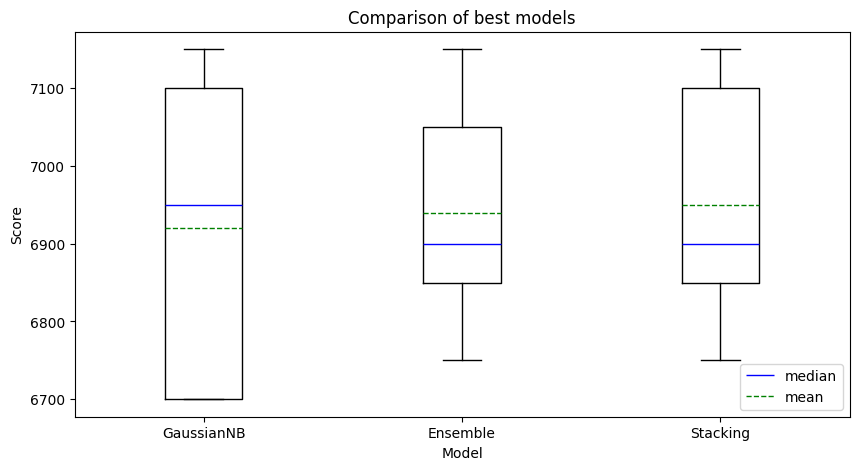

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bp = plt.boxplot([exp_gnb.scores, exp_ensemble.scores, exp_stacking.scores], 
                 showmeans=True, meanline=True, meanprops={'color': 'green'}, medianprops={'color': 'blue'}, 
            boxprops={'color': 'black'}, whiskerprops={'color': 'black'}, capprops={'color': 'black'}, 
            )
plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'], loc='lower right')
plt.xticks([1, 2, 3], ['GaussianNB', 'Ensemble', 'Stacking'])
plt.ylabel("Score")
plt.xlabel("Model")
plt.title("Comparison of best models")
plt.show()

In [37]:
np.mean([exp_gnb.scores, exp_ensemble.scores, exp_stacking.scores], axis=1)

array([6920., 6940., 6950.])